In [141]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
#from sklearn.model_selection import train_test_split

import seaborn as sns
import numpy as np
import re
import os
import treedata

In [142]:
%load_ext autoreload
%autoreload 2
    
from helpers.utils import _qq_stats_text
from helpers.utils import scree
from helpers.utils import learn_kde
from helpers.utils import score_with_kdes
from helpers.utils import reshape_to_cmat, _site_slice
import helpers.utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
plot_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/"
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"

In [144]:
training_data = out_dir + "petracer_full_training.csv"
barcoded_tracing_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/barcoded_tracing_alleles.csv"
colony_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/colony_alleles.csv"
# barcoded_unfiltered_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/240517_colony/decoded_spots.csv"
barcoded_meta_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/28473866/barcoded_tracing_clone_4.h5td"

In [145]:
codebook_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/edit_codebook.csv"

### Read inputs

In [146]:
barcoded_df = pd.read_csv(barcoded_tracing_fname).fillna("unedited")
colony_df = pd.read_csv(colony_fname, index_col=0).fillna("unedited")
barcoded_unfiltered_df = pd.read_csv(barcoded_unfiltered_fname).fillna("unedited")
codebook = pd.read_csv(codebook_fname)
codebook_df = codebook.copy().fillna("unedited")

In [147]:
# barcoded_meta = treedata.read_h5td(barcoded_meta_fname)

In [148]:
colony_df.columns

Index(['intID', 'cellBC', 'HEK3', 'EMX1', 'RNF2', 'spot', 'x', 'y', 'z',
       'global_x', 'global_y', 'global_z', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6',
       'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16',
       'r17', 'r18', 'r19', 'r20', 'r21', 'r25', 'r26', 'r27', 'r28', 'r29',
       'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'r36', 'r37', 'r38', 'r39',
       'r40', 'r41', 'r42', 'r43', 'r44', 'r45', 'r46', 'r47', 'r48', 'r49',
       'r50', 'r51', 'intBC_dist', 'intBC_intensity', 'intBC_snr', 'HEK3_prob',
       'HEK3_intensity', 'HEK3_snr', 'EMX1_prob', 'EMX1_intensity', 'EMX1_snr',
       'RNF2_prob', 'RNF2_intensity', 'RNF2_snr', 'sample', 'colony', 'clone'],
      dtype='object')

In [149]:
for x in colony_df['clone'].unique():
    print(x, colony_df[colony_df['clone'] == x]['cellBC'].nunique())
print(len(colony_df['clone'].unique()), "colonies in total")

41 105
34 169
14 426
15 386
29 230
30 223
5 721
10 534
48 79
50 73
16 376
19 358
8 568
59 41
61 29
49 73
46 82
11 484
36 156
44 92
25 262
42 102
12 447
9 557
38 138
28 238
3 832
20 351
64 20
4 804
13 433
23 268
7 615
22 337
39 133
53 60
17 361
43 99
32 197
47 82
58 47
60 34
6 659
54 60
26 258
27 238
37 142
45 81
52 62
2 942
31 205
55 55
21 345
63 23
40 108
62 27
35 160
57 47
51 67
33 177
24 262
1 1397
18 355
56 51
64 colonies in total


In [150]:
mask = barcoded_df['clone'] == 4
seq_df = barcoded_df[mask]
print(seq_df['cellBC'].nunique())

3108


In [151]:
mask = colony_df['clone'] == 3
img_df = colony_df[mask]
print(img_df['cellBC'].nunique())

832


In [152]:
dup_counts = seq_df.groupby(["cellBC", "intID"]).size().reset_index(name="count")

dup_counts[dup_counts["count"] > 1]

,cellBC,intID,count


`barcoded_df` only has sequencing data (scRNA-seq readout). We don't observe any allele conflicts here. I may be able to go a bit earlier in the pipeline and find the data with allele conflicts. 

Let's focus on doing the colony_df analysis for now. We can only show it scales to 800 cells for now. Colony 1 has 1397 cells. 

In [153]:
img_df

,intID,cellBC,HEK3,EMX1,RNF2,spot,x,y,z,global_x,...,HEK3_snr,EMX1_prob,EMX1_intensity,EMX1_snr,RNF2_prob,RNF2_intensity,RNF2_snr,sample,colony,clone
4827,intID1011,colony-21229,CTTTG,CCCTA,unedited,1006,208,1982,4,-2221.994,...,11.328,1.000,2548.245,15.774,0.995,2782.459,7.992,colony,6,3
4829,intID1011,colony-21230,unedited,CCCTA,GTTCA,6879,260,2127,19,-2216.430,...,7.561,0.998,1088.737,7.047,0.917,673.763,3.919,colony,6,3
4831,intID1011,colony-21240,unedited,CCCTA,TTCCT,5461,518,2091,15,-2188.824,...,5.193,0.990,902.280,5.481,0.972,829.382,4.383,colony,6,3
4832,intID1011,colony-21241,unedited,CCCTA,GTTCA,49,734,2110,13,-2165.712,...,19.432,1.000,12181.857,24.036,0.999,8758.920,10.752,colony,6,3
4833,intID1011,colony-21244,CTCTC,CCCTA,GTTCA,2135,1693,2138,10,-2063.099,...,10.214,1.000,3651.985,17.897,1.000,3558.197,17.950,colony,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164634,intID911,colony-22490,unedited,unedited,unedited,1045,821,2046,19,-1720.153,...,8.794,0.999,2475.268,11.559,0.998,2748.468,9.442,colony,6,3
164635,intID911,colony-22494,unedited,CCCTA,unedited,3056,2040,2213,23,-1810.720,...,6.531,0.941,705.107,3.957,0.640,552.364,2.943,colony,6,3
164636,intID911,colony-22501,unedited,unedited,TTCCT,2148,243,1540,21,-1781.999,...,8.023,0.968,1099.833,5.287,0.946,819.079,3.869,colony,6,3
164637,intID911,colony-22504,unedited,unedited,unedited,317,267,2078,14,-1779.431,...,12.763,0.999,3877.748,10.640,0.999,4814.674,10.833,colony,6,3


In [154]:
df_test_filtered = img_df.copy()

In [155]:
df_train = pd.read_csv(training_data).copy().fillna("unedited")

In [156]:
id_cols    = ["cellBC", "intID", "clone"]

pieces = [
    _site_slice(df_test_filtered, "HEK3", id_cols, codebook_df),
    _site_slice(df_test_filtered, "EMX1", id_cols, codebook_df),
    _site_slice(df_test_filtered, "RNF2", id_cols, codebook_df),
]
df_test = pd.concat(pieces, axis=0, ignore_index=True)

In [157]:
unique_cassettes = df_test['intID'].unique()
cassette_mapping = {id_: i for i, id_ in enumerate(unique_cassettes)}
df_test["cassette_idx"] = df_test["intID"].map(cassette_mapping)

site_mapping = {'RNF2': 0, 'HEK3': 1, 'EMX1': 2}
df_test['target_idx'] = df_test['target_site'].map(site_mapping) + len(site_mapping) * df_test["cassette_idx"]

In [158]:
feature_cols = [f"feature_{x}" for x in range(9)]

In [161]:
sites = df_train['target_site'].unique()
all_kde_dict_X, all_kde_dict_Z = {}, {}

preds_X_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])
preds_Z_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])
scores_X_tables = []
scores_Z_tables = []

min_pts = 2
for site in sites:
    mask_train = df_train['target_site'] == site
    site_df_train = df_train.loc[mask_train]
    mask_test = df_test['target_site'] == site
    site_df_test = df_test.loc[mask_test]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(site_df_train[feature_cols].values.copy())
    X_test = scaler.transform(site_df_test[feature_cols].values.copy())

    pca = PCA(n_components=9, random_state=0, svd_solver='full', whiten=False)
    Z_train = pca.fit_transform(X_train.copy())
    Z_test  = pca.transform(X_test.copy())

    all_kde_dict_X[site] = {}
    all_kde_dict_Z[site] = {}
    labels = site_df_train["seq_state"].unique()

    for lab in labels:
        m_train = site_df_train["seq_state"].eq(lab)   # boolean mask over df_train rows
        n = int(m_train.sum())
        if n < min_pts:
            continue

        X_block = X_train[m_train.values, :]   # raw feature space (scaled)
        Z_block = Z_train[m_train.values, :]   # PCA space

        kde_X = learn_kde(X_block)
        all_kde_dict_X[site][lab] = kde_X
        kde_Z = learn_kde(Z_block)
        all_kde_dict_Z[site][lab] = kde_Z

    # test
    pred_cols = ["pred_label","argmax_idx","argmax_logpdf"]
    
    # --- X space ---
    preds_X, scores_X = score_with_kdes(X_test, all_kde_dict_X[site])
    # write predictions into the preallocated frame using the boolean mask
    preds_X_full.loc[mask_test, pred_cols] = preds_X[pred_cols].to_numpy()
    # scores: align to df_test via the site’s original indices, then prefix columns
    scores_X.index = site_df_test.index
    scores_X = scores_X.add_prefix(f"{site}::")
    scores_X_tables.append(scores_X)
    print("Scored X...")
    
    # --- Z space ---
    preds_Z, scores_Z = score_with_kdes(Z_test, all_kde_dict_Z[site])
    preds_Z_full.loc[mask_test, pred_cols] = preds_Z[pred_cols].to_numpy()
    scores_Z.index = site_df_test.index
    scores_Z = scores_Z.add_prefix(f"{site}::")
    scores_Z_tables.append(scores_Z)
    print("Scored Z...")

Scored X...
Scored Z...
Scored X...
Scored Z...
Scored X...
Scored Z...


In [264]:
# Clean types
preds_X_full["argmax_idx"] = pd.to_numeric(preds_X_full["argmax_idx"], errors="coerce")
preds_X_full["argmax_logpdf"] = pd.to_numeric(preds_X_full["argmax_logpdf"], errors="coerce")

preds_Z_full["argmax_idx"] = pd.to_numeric(preds_Z_full["argmax_idx"], errors="coerce")
preds_Z_full["argmax_logpdf"] = pd.to_numeric(preds_Z_full["argmax_logpdf"], errors="coerce")

out = (
    df_test
    .join(preds_X_full.add_prefix("X_"))
    .join(preds_Z_full.add_prefix("Z_"))
)

In [265]:
out.columns

Index(['cellBC', 'intID', 'clone', 'target_site', 'pet_state', 'pet_prob',
       'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_0_bit',
       'feature_0_edit', 'feature_1_bit', 'feature_1_edit', 'feature_2_bit',
       'feature_2_edit', 'feature_3_bit', 'feature_3_edit', 'feature_4_bit',
       'feature_4_edit', 'feature_5_bit', 'feature_5_edit', 'feature_6_bit',
       'feature_6_edit', 'feature_7_bit', 'feature_7_edit', 'feature_8_bit',
       'feature_8_edit', 'cassette_idx', 'target_idx', 'X_pred_label',
       'X_argmax_idx', 'X_argmax_logpdf', 'Z_pred_label', 'Z_argmax_idx',
       'Z_argmax_logpdf'],
      dtype='object')

In [266]:
out[['pet_state', 'X_pred_label']]

,pet_state,X_pred_label
0,CTTTG,CTTTG
1,unedited,unedited
2,unedited,unedited
3,unedited,unedited
4,CTCTC,CTCTC
...,...,...
30085,unedited,unedited
30086,unedited,unedited
30087,TTCCT,TTCCT
30088,unedited,unedited


In [267]:
out['X_argmax_logpdf'].describe()

count    30090.000000
mean        -1.231523
std         38.000645
min       -690.775528
25%          0.217247
50%          3.995453
75%          6.194240
max         12.068783
Name: X_argmax_logpdf, dtype: float64

In [268]:
out['Z_argmax_logpdf'].describe()

count    30090.000000
mean        -3.210486
std         18.907157
min       -690.775528
25%         -4.335630
50%         -1.060188
75%          1.154760
max          8.589286
Name: Z_argmax_logpdf, dtype: float64

In [182]:
np.mean(out['X_pred_label'] != out['pet_state'])

np.float64(0.0325024925224327)

In [183]:
df_clean = df_test.copy()

In [184]:
df_clean['kde_pred_string'] = preds_X_full['pred_label']

all_idx = [x.index for x in scores_X_tables]

for i, idx in enumerate(all_idx):
    dupes = idx[idx.duplicated()]
    if len(dupes):
        print(f"[warn] scores_X_tables[{i}] has {len(dupes)} duplicate indices!")
    else:
        print(f"[ok] scores_X_tables[{i}] indices are unique.")

[ok] scores_X_tables[0] indices are unique.
[ok] scores_X_tables[1] indices are unique.
[ok] scores_X_tables[2] indices are unique.


In [185]:
all_idx = pd.Index([]).append([x.index for x in scores_X_tables])

# check equality with df_clean
print("same length:", len(all_idx) == len(df_clean))
print("same members:", set(all_idx) == set(df_clean.index))

same length: True
same members: True


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_91075/210554016.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_idx = pd.Index([]).append([x.index for x in scores_X_tables])


In [186]:
site_states = {}

for df in scores_X_tables:
    for c in df.columns:
        if "::state" not in c:
            continue
        site, label = c.split("::state")
        label = label.replace("_prob", "")
        site_states.setdefault(site, set()).add(label)

# --- Build the codebook ---
rows = []
for site, labels in site_states.items():
    # ensure 'unedited' is 0, others get 1..8 sorted alphabetically
    labels_sorted = sorted([l for l in labels if l != "unedited"])
    ordered = ["unedited"] + labels_sorted
    for i, lbl in enumerate(ordered):
        rows.append({"site": site, "label": lbl, "code": i})

label_codebook = pd.DataFrame(rows).sort_values(["site", "code"], ignore_index=True)
print(label_codebook)
label_codebook.to_csv(out_dir + "/petracer_colonies_codebook.csv", index=False) 

    site     label  code
0   EMX1  unedited     0
1   EMX1     ACAAT     1
2   EMX1     AGTAC     2
3   EMX1     ATCAA     3
4   EMX1     ATTCG     4
5   EMX1     CCCTA     5
6   EMX1     CCGAT     6
7   EMX1     CCTTT     7
8   EMX1     GGACA     8
9   HEK3  unedited     0
10  HEK3     AATCG     1
11  HEK3     ATCAA     2
12  HEK3     ATTTA     3
13  HEK3     CTCTC     4
14  HEK3     CTTTG     5
15  HEK3     GATAG     6
16  HEK3     GCAAG     7
17  HEK3     GCGCC     8
18  RNF2  unedited     0
19  RNF2     ACAGT     1
20  RNF2     ACTCC     2
21  RNF2     ACTTA     3
22  RNF2     GTTCA     4
23  RNF2     TATAT     5
24  RNF2     TCCAA     6
25  RNF2     TGCCA     7
26  RNF2     TTCCT     8


In [187]:
# make sure df_clean has 9 columns ready (will fill in order)
for i in range(9):
    col = f"state{i}_prob"
    if col not in df_clean.columns:
        df_clean[col] = pd.NA  # initialize

for site, df_scores in zip(sites, scores_X_tables):
    # ensure we’re using the actual indices from this score table
    idx = df_scores.index  

    # mapping: label -> code
    site_map = (
        label_codebook.query("site == @site")
        .set_index("label")["code"]
        .to_dict()
    )

    for col in df_scores.columns:
        m = re.match(r"(.+)::state(.+)_prob", col)
        if not m:
            continue
        _, label = m.groups()
        code = site_map.get(label.strip())
        if code is None:
            continue

        target_col = f"state{code}_prob"
        df_clean.loc[idx, target_col] = df_scores[col].values
        
state_cols = sorted(
    [c for c in df_clean.columns if re.match(r"state\d+_prob", c)],
    key=lambda x: int(re.search(r"\d+", x).group())
)
other_cols = [c for c in df_clean.columns if c not in state_cols]
df_clean = df_clean[other_cols + state_cols]

df_clean

,cellBC,intID,clone,target_site,pet_state,pet_prob,feature_0,feature_1,feature_2,feature_3,...,kde_pred_string,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
0,colony-21229,intID1011,3,HEK3,CTTTG,1.000,151.968,382.201,93.477,108.180,...,CTTTG,-12.684732,-15.452411,-10.057569,-13.624432,-24.412698,4.737122,-7.337136,-22.128372,-9.710306
1,colony-21230,intID1011,3,HEK3,unedited,0.993,158.407,176.455,146.892,136.513,...,unedited,7.392207,-1.521483,-0.982605,0.310129,0.07187,0.209787,-0.595876,0.138454,-1.271573
2,colony-21240,intID1011,3,HEK3,unedited,0.950,132.650,127.877,152.962,191.891,...,unedited,7.309843,2.53493,2.262321,2.974935,3.328735,4.052736,2.631727,3.966514,0.709571
3,colony-21241,intID1011,3,HEK3,unedited,1.000,615.597,1355.207,345.986,404.388,...,unedited,-5.250777,-690.775528,-690.775528,-690.775528,-690.775528,-134.750209,-516.268361,-301.547281,-690.775528
4,colony-21244,intID1011,3,HEK3,CTCTC,1.000,226.663,202.174,126.255,150.680,...,CTCTC,-4.003167,-57.599464,-46.6332,-45.34152,6.469248,-16.939477,-32.491839,-23.135951,-10.801353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30085,colony-22490,intID911,3,RNF2,unedited,0.998,329.336,166.316,234.391,257.896,...,unedited,8.449224,-114.519071,-689.968072,-149.400879,-128.313168,-22.996711,-6.728401,-2.021969,-1.186438
30086,colony-22494,intID911,3,RNF2,unedited,0.640,132.163,213.662,211.209,146.451,...,unedited,8.066773,2.603515,1.858138,1.286042,2.154465,3.325773,5.083569,2.627774,3.295546
30087,colony-22501,intID911,3,RNF2,TTCCT,0.946,237.179,231.872,819.079,149.308,...,TTCCT,-2.372812,0.627857,1.952656,-0.61128,-3.627261,-2.071359,-4.428669,-1.473117,7.558545
30088,colony-22504,intID911,3,RNF2,unedited,0.999,855.130,239.156,242.118,455.069,...,unedited,4.618055,-8.323058,-690.775528,-558.309472,-566.694396,-8.745352,-9.037774,-6.196311,-5.026406


In [188]:
df_clean.columns

Index(['cellBC', 'intID', 'clone', 'target_site', 'pet_state', 'pet_prob',
       'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_0_bit',
       'feature_0_edit', 'feature_1_bit', 'feature_1_edit', 'feature_2_bit',
       'feature_2_edit', 'feature_3_bit', 'feature_3_edit', 'feature_4_bit',
       'feature_4_edit', 'feature_5_bit', 'feature_5_edit', 'feature_6_bit',
       'feature_6_edit', 'feature_7_bit', 'feature_7_edit', 'feature_8_bit',
       'feature_8_edit', 'cassette_idx', 'target_idx', 'kde_pred_string',
       'state0_prob', 'state1_prob', 'state2_prob', 'state3_prob',
       'state4_prob', 'state5_prob', 'state6_prob', 'state7_prob',
       'state8_prob'],
      dtype='object')

In [189]:
df_clean = df_clean.merge(
    label_codebook.rename(columns={
        "site": "target_site",
        "label": "kde_pred_string",
        "code": "kde_pred_label"
    }),
    on=["target_site", "kde_pred_string"],
    how="left"
)

lookup_codebook = (
    df_clean[["target_idx", "kde_pred_string", "kde_pred_label"]]
    .drop_duplicates()
    .sort_values(["target_idx", "kde_pred_label"], ignore_index=True)
)

lookup_codebook.to_csv(out_dir + "/petracer_barcode_lookup_codebook.csv", index=False)

In [190]:
tbl = df_clean[['target_idx', 'cellBC', 'kde_pred_label']]
tbl.columns = ['target_site', 'cell_name', 'pred_label']

In [191]:
kde_inputs_argmax = reshape_to_cmat(tbl).T

In [197]:
kde_inputs_argmax.to_csv(out_dir + "/petracer_colonies_clone3_kde_character_matrix.csv")

In [198]:
(kde_inputs_argmax == -1).sum().sum() / (kde_inputs_argmax.shape[0] * kde_inputs_argmax.shape[1]), (kde_inputs_argmax.shape)

(np.float64(0.24654447115384615), (832, 48))

In [199]:
832 * 48, .03 * (832 * 48 * (1-0.2465))

(39936, 902.75328)

We marked 900 sites differently.

In [200]:
clone = 3

In [201]:
# [id_cols + ["cassette_idx", "target_idx", "target_site", "seq_state", "pet_state", "brightest_state", "pet_prob"]]
petracer_df = df_clean.copy()
petracer_path = os.path.join(out_dir, f"petracer_colonies_clone{clone}_petracer_genotypes.csv")
petracer_df.to_csv(petracer_path, index=False)

In [202]:
state_cols = [c for c in df_clean.columns if re.match(r"state\d+_prob", c)]
obs_matrix = df_clean[["cellBC", "cassette_idx", "target_idx"] + state_cols].copy().rename(columns={"cellBC": "cell_name", "target_idx": "target_site"})
obs_matrix["cassette_idx"] = 0
obs_matrix = obs_matrix.sort_values(by="target_site", ascending=True)
petracer_path = os.path.join(out_dir, f"petracer_colonies_clone{clone}_kde_scores.csv")
obs_matrix.to_csv(petracer_path, index=False)


In [203]:
pd.to_numeric(obs_matrix['state0_prob'], errors='coerce').describe()

count    30090.000000
mean      -123.790451
std        232.683778
min       -690.775528
25%        -95.259126
50%         -7.171165
75%          3.407954
max          9.235439
Name: state0_prob, dtype: float64

In [250]:
obs_matrix['cell_name'].nunique()

832

### Try reading in PEtracer tree

In [204]:
import treedata

In [207]:
colony_petracer_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/28473866/colony_tracing.h5ad"
colony_pet_df = treedata.read_h5ad(colony_petracer_fname)

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_91075/880964046.py:2: DeprecationWarning: read_h5ad has been renamed to read_h5td. read_h5ad will be removed in v1.0.0.
  colony_pet_df = treedata.read_h5ad(colony_petracer_fname)


In [210]:
colony_pet_df

TreeData object with n_obs × n_vars = 18675 × 0
    obs: 'fov', 'centroid_x', 'centroid_y', 'centroid_z', 'n_layers', 'volume', 'sample', 'cellBC', 'type', 'colony', 'clone', 'detection_rate', 'tree'
    uns: 'clone_characters', 'clone_colors', 'colony_colors'
    obsm: 'characters', 'spatial'
    obst: '37', '30', '59', '32', '34', '5', '38', '28', '52', '51', '18', '7', '22', '39', '53', '24', '17', '43', '47', '58', '62', '35', '60', '6', '54', '26', '27', '2', '14', '29', '15', '10', '63', '48', '50', '8', '16', '19', '31', '1', '61', '49', '46', '40', '11', '57', '36', '44', '25', '45', '42', '55', '33', '12', '9', '3', '41', '20', '64', '21', '56', '4', '13', '23'

In [240]:
colony_pet_df.obs.loc[colony_pet_df.obs['cellBC'] == 'colony-22310']

,fov,centroid_x,centroid_y,centroid_z,n_layers,volume,sample,cellBC,type,colony,clone,detection_rate,tree
colony-22310,228,-1693.564121,-1410.954351,-8.173423,28,2052.659153,colony,colony-22310,tracing,6,3,0.625,3


In [251]:
colony_pet_df.obs.loc[colony_pet_df.obs['clone'] == '3', 'cellBC'].nunique()

834

In [252]:
[x for x in colony_pet_df.obs.loc[colony_pet_df.obs['clone'] == '3', 'cellBC'].unique() if x not in obs_matrix['cell_name'].unique()]

['colony-21911', 'colony-22216']

In [241]:
# colony_pet_df.uns['clone_characters']['3']

In [242]:
petracer_tree_digraph = colony_pet_df.obst['6']

In [218]:
import networkx as nx

def digraph_to_newick(G: nx.DiGraph,
                      root=None,
                      length_attr=None,      # e.g. "length" or "weight" on edges
                      label_attr=None,       # e.g. "name" on nodes; defaults to node id
                      include_internal_labels=False,
                      round_digits=None) -> str:
    """
    Convert a rooted arborescence (tree) in NetworkX DiGraph to a Newick string.
    """
    if root is None:
        roots = [n for n in G.nodes if G.in_degree(n) == 0]
        if len(roots) != 1:
            raise ValueError(f"Need exactly one root (found {len(roots)}). Pass root= explicitly.")
        root = roots[0]

    # Must be a tree with edges pointing away from the root (arborescence)
    if not nx.is_arborescence(G):
        raise ValueError("DiGraph is not an arborescence (it has cycles or multiple parents).")

    def node_label(n):
        return str(G.nodes[n].get(label_attr, n)) if label_attr else str(n)

    def edge_suffix(u, v):
        if length_attr is None:
            return ""
        val = G.edges[u, v].get(length_attr, None)
        if val is None:
            return ""
        if round_digits is not None:
            val = round(val, round_digits)
        return f":{val}"

    def rec(u):
        children = list(G.successors(u))
        if not children:
            return node_label(u)
        parts = [rec(v) + edge_suffix(u, v) for v in children]
        s = "(" + ",".join(parts) + ")"
        if include_internal_labels:
            s += node_label(u)
        return s

    # Handle single-node tree
    if G.number_of_nodes() == 1:
        return node_label(next(iter(G.nodes))) + ";"

    return rec(root) + ";"


In [219]:
G = nx.DiGraph()
G.add_edges_from([
    ("A","B"), ("A","C"), ("B","D"), ("B","E")
])
# Optional lengths
nx.set_edge_attributes(G, {
    ("A","B"): 0.1, ("A","C"): 0.2, ("B","D"): 0.3, ("B","E"): 0.4
}, "length")

newick = digraph_to_newick(G, root="A", length_attr="length")
print(newick)

((D:0.3,E:0.4):0.1,C:0.2);


In [221]:
import treeswift

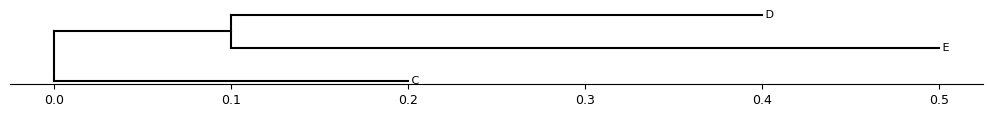

In [226]:
t = treeswift.read_tree_newick(newick)
t.draw(show_labels=True, )

In [227]:
for x in t.traverse_preorder():
    print(x.label)

None
C
None
E
D


In [229]:
[n for n, d in petracer_tree_digraph.in_degree() if d == 0]

['node0']

In [236]:

newick = digraph_to_newick(petracer_tree_digraph, root="node0", length_attr="length")
t = treeswift.read_tree_newick(newick)

In [237]:
t.write_tree_newick('/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies/clone3.petracer.neighbor_joining.nwk')

In [238]:
t.resolve_polytomies()

In [254]:
# drop two taxa which don't have corresponding data
to_drop = ['colony-21911', 'colony-22216']
t = t.extract_tree_without(to_drop, suppress_unifurcations=True)

In [255]:
t.write_tree_newick('/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies/clone3.petracer.neighbor_joining.binary.nwk')